In [36]:
import numpy as np
import pygam
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import itertools
import scipy as sp
import scipy.cluster.hierarchy
from scipy.cluster.hierarchy import fcluster
import pandas as pd
import seaborn as sb
plt.style.use('default')

import sys
sys.path.append("../../scripts")
import visutil

In [2]:
DATA_DIR = "../../data/mESC/"
FIG_DIR = "./"

In [3]:
try:
    my_purple = matplotlib.colors.LinearSegmentedColormap.from_list("MyPurple", ['purple', 'purple', ])
    matplotlib.colormaps.register(cmap = my_purple)
    my_red = matplotlib.colors.LinearSegmentedColormap.from_list("MyRed", ['red', 'red', ])
    matplotlib.colormaps.register(cmap = my_red)
    my_grey = matplotlib.colors.LinearSegmentedColormap.from_list("MyGrey", ['#595959', '#595959', ])
    matplotlib.colormaps.register(cmap = my_grey)
except:
    pass

In [7]:
adata = ad.AnnData(np.load(DATA_DIR+"X.npy"))
adata.obs["dpt"] = np.load(DATA_DIR+"dpt.npy")
adata.var["gene"] = np.load(DATA_DIR+"genes.npy")
adata.var["gene"] = adata.var["gene"].str.capitalize()
G = np.load(DATA_DIR+"G.npy")
G = np.swapaxes(G.reshape(-1, adata.shape[1], adata.shape[1]), 1, 2).reshape(-1, adata.shape[1]**2) # fix Julia orientation
U = np.load(DATA_DIR+"U.npy")
V = np.load(DATA_DIR+"V.npy")
V = np.swapaxes(V.reshape(adata.shape[1], adata.shape[1], -1), 0, 1).reshape(adata.shape[1]**2, -1) # fix Julia orientation
adata.varm["J"] = np.load(DATA_DIR+"J.npy")
adata.varm["J_ESCAPE"] = np.load(DATA_DIR+"J_ESCAPE.npy")

(-0.5, 455.5, -0.5, 7.5)

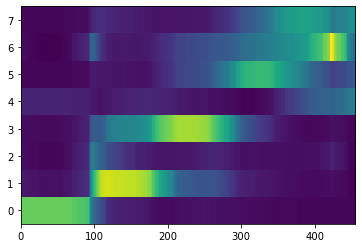

In [24]:
coeff_gam = [pygam.LinearGAM(pygam.s(0)).fit(adata.obs.dpt, u) for u in U.T]
U_gam = np.vstack([g.predict(adata.obs.dpt) for g in coeff_gam]).T
perm = np.argsort([np.dot(adata.obs.dpt, x / sum(x)) for x in U_gam.T])
plt.imshow(U_gam[np.argsort(adata.obs.dpt), :][:, perm].T, interpolation = "none", origin = "lower")
plt.axis("auto")

Text(331.49999999999994, 0.5, 'Regulatory module')

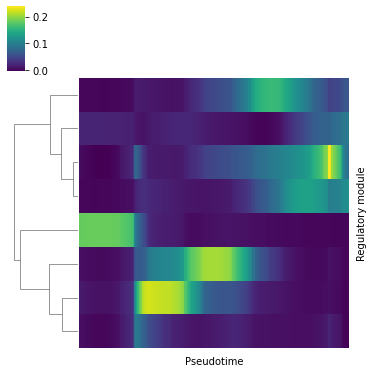

In [25]:
cg = sb.clustermap(U_gam[np.argsort(adata.obs.dpt), :].T, row_cluster = True, col_cluster = False, metric = "correlation", xticklabels = False, yticklabels = False, figsize = (5, 5), cmap = "viridis")
cg.ax_heatmap.set_xlabel("Pseudotime")
cg.ax_heatmap.set_ylabel("Regulatory module")

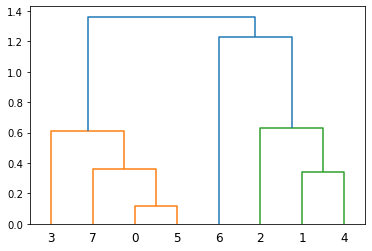

In [26]:
Z = cg.dendrogram_row.calculated_linkage
scipy.cluster.hierarchy.dendrogram(Z);

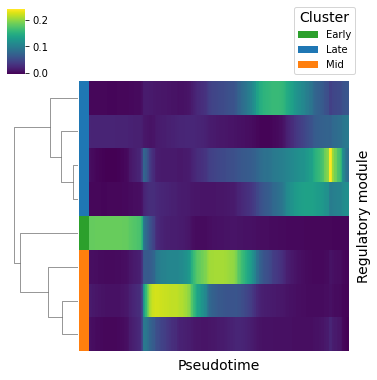

In [28]:
clusterids = fcluster(Z, 3, criterion = 'maxclust')
colordict = {i : matplotlib.cm.get_cmap('tab10')(i-1) for i in range(1, 3+1)}
clusterdict = {3 : "Early", 1 : "Late", 2 : "Mid"}
colors = [colordict[i] for i in clusterids]

from matplotlib.patches import Patch
cg = sb.clustermap(U_gam[np.argsort(adata.obs.dpt), :].T, row_cluster = True, col_cluster = False, metric = "correlation", xticklabels = False, yticklabels = False, figsize = (5, 5), cmap = "viridis", row_colors = colors, rasterized = True)
cg.ax_heatmap.set_xlabel("Pseudotime", fontsize = 14)
cg.ax_heatmap.set_ylabel("Regulatory module", fontsize = 14)

idxs = [3, 1, 2]
handles = [Patch(facecolor=colordict[i]) for i in idxs]
plt.legend(handles, [clusterdict[i] for i in idxs], title='Cluster',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right', title_fontsize = 14)
cg.savefig(FIG_DIR + "hayashi_nmf_coeffs.pdf")

In [54]:
import importlib
importlib.reload(visutil)

<module 'visutil' from '/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/mESC/../../scripts/visutil.py'>

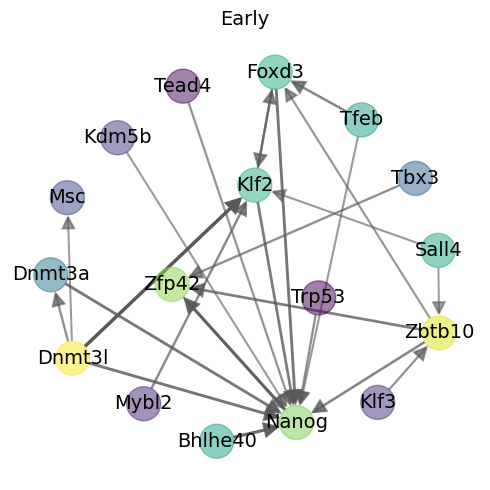

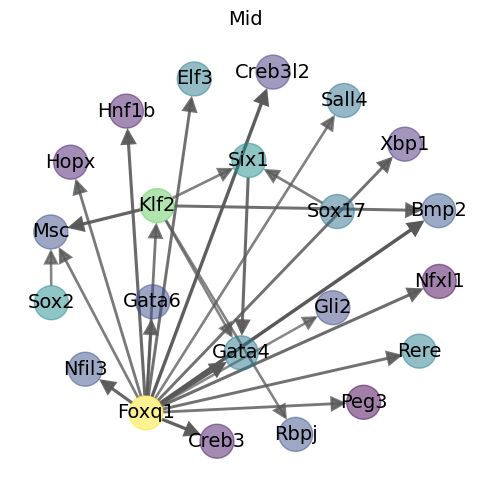

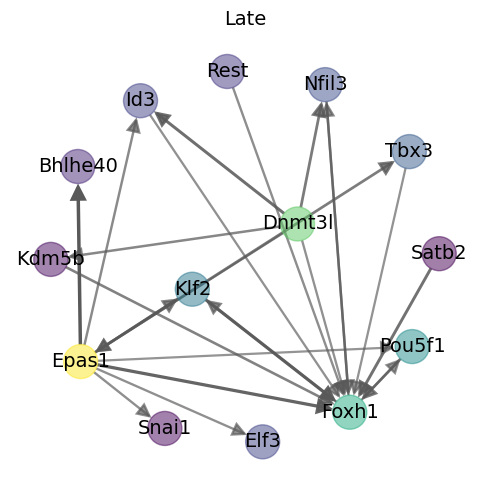

In [55]:
stage = np.array([clusterdict[i] for i in clusterids])
for s in ["Early", "Mid", "Late"]:
    plt.figure(figsize = (5, 5))
    A = np.dot(np.mean(U * (stage == s), 0), V.T)
    g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
    nx.set_edge_attributes(g, {(i, j) : adata.varm["J"][i, j] for (i, j) in g.edges}, name = "ref")
    nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
    visutil.draw(g, adata.var['gene'], thresh = 0.9975, layout_args = "-Gstart=1")
    plt.gca().axis("off")
    plt.title(s, fontsize = 14)
    plt.tight_layout()
    plt.savefig(FIG_DIR + "hayashi_nmf_network_%s.pdf" % s)

In [56]:
# top-k out edges
def outedge_counts(A, cutoff = 1_000):
    cutoff = np.sort(A.flatten())[::-1][cutoff]
    A[A <= cutoff] = 0
    return np.sum(A > 0, -1)

def outedge_eigen_centrality(A):
    g = nx.DiGraph(A)
    nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
    nodes, centrality = zip(*nx.get_node_attributes(g,'centrality').items())
    return centrality

for s in ["Early", "Mid", "Late"]:
    A = np.dot(np.mean(U * (stage == s), 0), V.T)
    # counts = outedge_counts(A.reshape(adata.shape[1], adata.shape[1]))
    # pd.DataFrame({s : adata.var.gene[np.argsort(counts)[::-1][0:25]]}).to_csv("genelist_nmf_%s.csv" % s, header = True, index = False)
    centrality = outedge_eigen_centrality(A.reshape(adata.shape[1], adata.shape[1]))
    pd.DataFrame({"gene" : adata.var.gene[np.argsort(centrality)[::-1][0:25]]}).to_csv("genelist_nmf_%s.csv" % s, header = True, index = False)

In [57]:
!paste -d, genelist_nmf_Early.csv genelist_nmf_Mid.csv genelist_nmf_Late.csv > genelist_nmf_all.csv

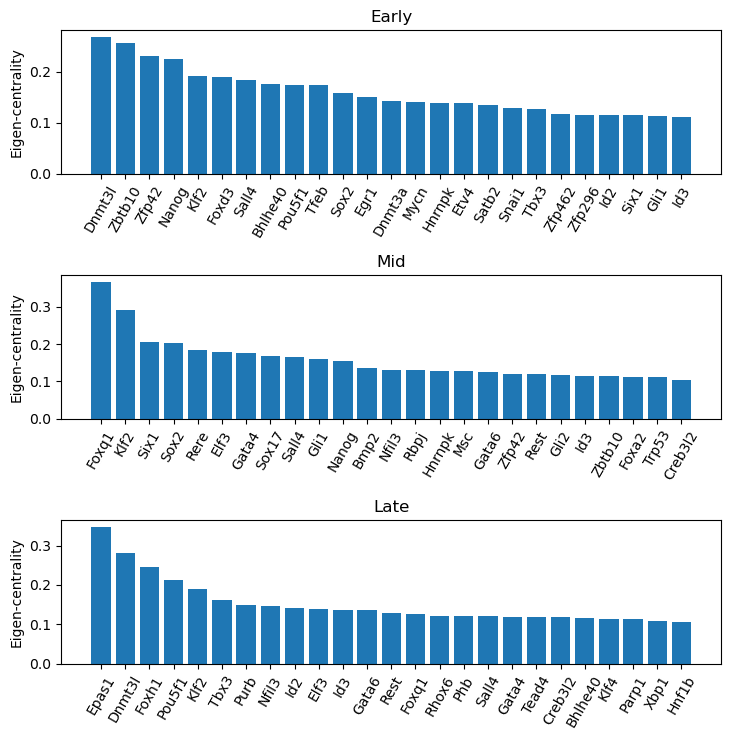

In [58]:
plt.figure(figsize = (7.5, 7.5))
for (i, s) in enumerate(["Early", "Mid", "Late"]):
    A = np.dot(np.mean(U * (stage == s), 0), V.T)
    # counts = outedge_counts(A.reshape(adata.shape[1], adata.shape[1]))
    # idx = np.argsort(counts)[::-1][0:25]
    centrality = np.array(outedge_eigen_centrality(A.reshape(adata.shape[1], adata.shape[1])))
    idx = np.argsort(centrality)[::-1][0:25]
    plt.subplot(3, 1, i+1)
    plt.bar(range(len(idx)), centrality[idx])
    plt.xticks(range(len(idx)), adata.var.gene[idx], rotation = 60);
    plt.title(s)
    plt.ylabel("Eigen-centrality")
plt.tight_layout()
plt.savefig(FIG_DIR + "hayashi_nmf_stage_centrality.pdf")

In [63]:
# background genes
pd.DataFrame({"gene" : adata.var.gene}).to_csv("genelist_background.csv", header = True, index = False)

(-17.303565000000003, 494.590565, -26.635540000000002, 482.22754)

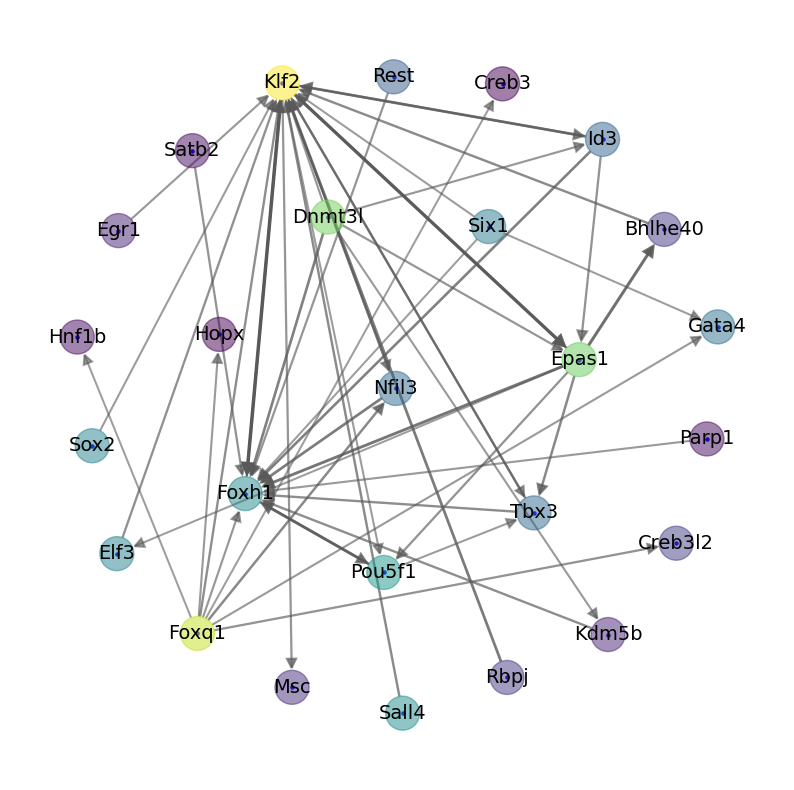

In [64]:
g = nx.DiGraph(np.mean(G[adata.obs.dpt < 0.9, :], axis = 0).reshape(adata.shape[1], adata.shape[1]))

nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
# get weights from g
edges,weights = zip(*nx.get_edge_attributes(g,'weight').items())
weights = np.array(list(weights))
weights /= np.max(weights)
# node and edgelist
nl = list(g.nodes())
el = list(g.edges())
edge_idx = np.where(weights > np.quantile(weights, 0.995))[0]
edgelist = [el[i] for i in edge_idx]

node_idx = list(set(itertools.chain(*edgelist)))
nodelist = [nl[i] for i in node_idx]
# take subgraph
g_sub = g.subgraph(nodelist)

# now plot
edges,weights = zip(*nx.get_edge_attributes(g_sub,'weight').items())
weights = np.array(list(weights))
weights /= np.quantile(weights, 0.999)
weights = np.minimum(1, weights)
edge_idx2 = np.where([e in edgelist for e in g_sub.edges()])[0]

fig = plt.figure(figsize = (10, 10))
# pos = nx.shell_layout(g_sub)
# pos = nx.spring_layout(g_sub, iterations = 250, seed = 0)
pos = nx.nx_agraph.graphviz_layout(g_sub, prog = 'fdp')
nx.draw_networkx_nodes(g_sub, pos, node_color = "b", node_size = 5)
arrows = nx.draw_networkx_edges(g_sub, pos, edgelist = edgelist, edge_color = weights[edge_idx2], alpha = weights[edge_idx2], width = 2.5*weights[edge_idx2], edge_cmap = matplotlib.colormaps["MyGrey"], edge_vmin = 0.1, node_size = 600)
for a, w in zip(arrows, weights):
    # from https://stackoverflow.com/questions/67251763/how-to-obtain-non-rounded-arrows-on-fat-lines
    a.set_mutation_scale(16 + w)
    a.set_joinstyle('miter')
    a.set_capstyle('butt')
nx.draw_networkx_labels(g_sub, pos, labels = {i : adata.var.gene[i] for i in g_sub.nodes()}, font_size = 14);
nodes, centrality = zip(*nx.get_node_attributes(g_sub,'centrality').items())
centrality /= np.max(centrality)
nx.draw_networkx_nodes(g, pos, nodelist = nodes, node_color = centrality, cmap = matplotlib.colormaps["viridis"], alpha = 0.5, node_size = 600)
plt.axis("off")

(-0.5, 455.5, 49.5, -0.5)

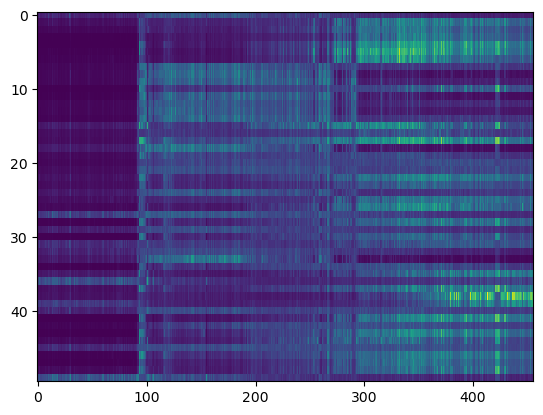

In [65]:
G_tensor = G.reshape(-1, adata.shape[1], adata.shape[1])
G_subset = np.vstack([G_tensor[:, i, j] for (i, j) in edgelist])
plt.imshow(G_subset[:, np.argsort(adata.obs.dpt)], interpolation = "none")
plt.axis("auto")

In [66]:
import seaborn as sb
gams = [pygam.LinearGAM(pygam.s(0)).fit(adata.obs.dpt, x) for x in G_subset]
G_gam = np.vstack([g.predict(adata.obs.dpt) for g in gams])
# G_gam /= G_gam.sum(-1).reshape(-1, 1)
row_perm = np.argsort(np.mean(G_gam * np.array(adata.obs.dpt).reshape(1, -1), -1))

/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


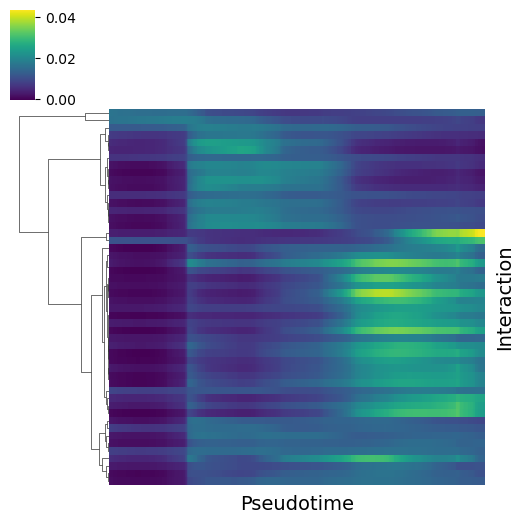

In [67]:
import scipy
cg = sb.clustermap(G_gam[:, np.argsort(adata.obs.dpt)], col_cluster = False, metric = "correlation", xticklabels = False, yticklabels = False, figsize = (5, 5), cmap = "viridis", rasterized = True)
cg.ax_heatmap.set_xlabel("Pseudotime", fontsize = 14)
cg.ax_heatmap.set_ylabel("Interaction", fontsize = 14)
cg.savefig(FIG_DIR + "hayashi_interactions_clustermap.pdf")

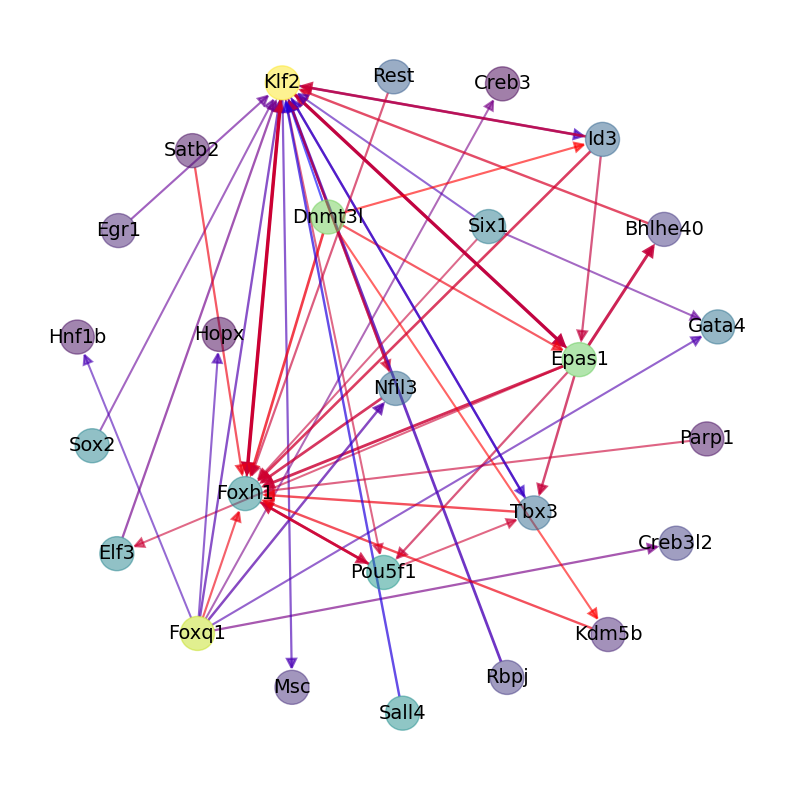

In [68]:
active_dpt = np.array(adata.obs.dpt)[np.argsort(G_gam, -1)[:, -1]]
# fig = plt.figure(figsize = (10, 10))
blue_red1 = matplotlib.colors.LinearSegmentedColormap.from_list("BlueRed1", ['blue', 'red'])
fig = plt.figure(figsize = (10, 10))
arrows = nx.draw_networkx_edges(g_sub, pos, edgelist = edgelist, edge_color = active_dpt, alpha = weights[edge_idx2], width = 2.5*weights[edge_idx2], edge_cmap = blue_red1, node_size = 600)
for a, w in zip(arrows, weights):
    # from https://stackoverflow.com/questions/67251763/how-to-obtain-non-rounded-arrows-on-fat-lines
    a.set_mutation_scale(16 + w)
    a.set_joinstyle('miter')
    a.set_capstyle('butt')
nx.draw_networkx_labels(g_sub, pos, labels = {i : adata.var.gene[i] for i in g_sub.nodes()}, font_size = 14);
nx.draw_networkx_nodes(g, pos, nodelist = nodes, node_color = centrality, cmap = matplotlib.colormaps["viridis"], alpha = 0.5, node_size = 600)
plt.axis("off")
plt.savefig(FIG_DIR + "hayashi_interactions_color_network.pdf")

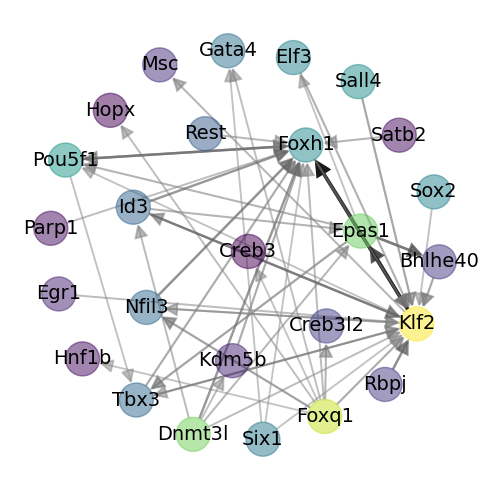

In [70]:
interactions = list(itertools.chain(*[[(adata.var.gene[i], adata.var.gene[j]) for j in range(adata.shape[1])] for i in range(adata.shape[1])]))
true_interactions = set([interactions[i] for i in np.where(adata.varm["J_ESCAPE"].flatten())[0]])
A = np.mean(G[adata.obs.dpt < 0.9, :], 0)
g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
fig = plt.figure(figsize = (5, 5))
visutil.draw(g, adata.var.gene, thresh = 0.995, cmap_dict = {0 : "Greys"}, layout_args = "-Gstart=2")
plt.axis("off")
plt.tight_layout()
plt.savefig(FIG_DIR + "hayashi_static_network.pdf")